## Make plots of ToE for Sea ice area/conc (OND & JFM), NPP (OND & JFM)

#### Set up paths

In [7]:
feisty_dir = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY'
data_dir = '/glade/derecho/scratch/kristenk/ToE_saved_data'
fig_dir = '/glade/work/kristenk/figs'
mask_dir = '/glade/u/home/kristenk/antarc_marine_pred_work/TOE'

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np
import matplotlib.path as mpath
import cmocean
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

### Get grid info

In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)
area_km2 = area * 1e-10

In [3]:
years = np.arange(1920,2101,1)

In [4]:
years = xr.DataArray(years,dims=('time'))

### Make a SIZ mask, so then we can do an area-weighted average for each longitude

In [26]:
##
ds_siz_mask = xr.open_dataset(f'{mask_dir}/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))

In [27]:
siz_mask = ds_siz_mask.SIZ

In [8]:
file = f'{data_dir}/CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(file)
ds_npp = ds_npp.isel(time=slice(70,250))
ds_npp = ds_npp.isel(nlat=slice(0,55))

In [9]:
file = f'{data_dir}/CESM2-LE-seasonal-means-IFRAC-hi_v4.nc'
ds_ice = xr.open_dataset(file)
ds_ice = ds_ice.isel(time=slice(70,250))
ds_ice

<xarray.Dataset>
Dimensions:       (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time          (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    IFRAC_OND     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JFM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JAS     (time, member_id, nlat, nlon) float64 ...
    IFRAC_SON     (time, member_id, nlat, nlon) float64 ...
    IFRAC_MAM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_AMJ     (time, member_id, nlat, nlon) float64 ...
    SIT_OND       (time, member_id, nlat, nlon) float64 ...
    SIT_JFM       (time, member_id, nlat, nlon) float64 ...
    SIT_AMJ       (time, member_id, nlat, nlon) float64 ...
    SIT_JAS       (time, member_id, nlat, nlon) float64 ...
    SIT_ONDJFM    (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly ifrac in the Southern Ocean from 1850 to 2099. Ea...

### Put all these together into one dataset

In [10]:
ds = xr.Dataset()
ds['NPP_OND'] = ds_npp.NPP_OND
ds['NPP_JFM'] = ds_npp.NPP_JFM
ds['NPP_AMJ'] = ds_npp.NPP_AMJ
ds['NPP_JAS'] = ds_npp.NPP_JAS
ds['IFRAC_AMJ'] = ds_ice.IFRAC_AMJ
ds['IFRAC_JAS'] = ds_ice.IFRAC_JAS
ds['IFRAC_OND'] = ds_ice.IFRAC_OND
ds['IFRAC_JFM'] = ds_ice.IFRAC_JFM
ds['SIT_JAS'] = ds_ice.SIT_JAS
ds['SIT_AMJ'] = ds_ice.SIT_AMJ
ds['SIT_JFM'] = ds_ice.SIT_JFM
ds['SIT_OND'] = ds_ice.SIT_OND

### Calculate ToE of seasonal sums/means

In [11]:
time3d = np.full([180,55,320],1,dtype=int)

In [12]:
ylen = 55
xlen = 320

for x in np.arange(0,xlen,1):
    for y in np.arange(0,ylen,1):

        time3d[:,y,x]=ds.time.values

time3d = xr.DataArray(time3d,dims=('time','nlat','nlon'))

#### calculate up/low thresholds for NPP, zooC, ice

In [13]:
%%time

# #### empty dictionaries, keys are variable names
upthres_ds = xr.Dataset()
lothres_ds = xr.Dataset()

variables=['IFRAC_OND','IFRAC_JFM','SIT_OND',
           'SIT_JFM','SIT_AMJ','SIT_JAS',
           'NPP_OND','NPP_JFM','NPP_AMJ','NPP_JAS',
           'IFRAC_AMJ','IFRAC_JAS']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 1.56 s, sys: 2.75 s, total: 4.31 s
Wall time: 5.63 s


In [18]:
ToE_up_npp_ond = time3d.where(ds.NPP_OND.mean(dim='member_id') > upthres_ds['NPP_OND'])
ToE_up_npp_ond = ToE_up_npp_ond.min(dim='time')

ToE_up_npp_jfm = time3d.where(ds.NPP_JFM.mean(dim='member_id') > upthres_ds['NPP_JFM'])
ToE_up_npp_jfm = ToE_up_npp_jfm.min(dim='time')

ToE_up_npp_amj = time3d.where(ds.NPP_AMJ.mean(dim='member_id') > upthres_ds['NPP_AMJ'])
ToE_up_npp_amj = ToE_up_npp_amj.min(dim='time')

ToE_up_npp_jas = time3d.where(ds.NPP_JAS.mean(dim='member_id') > upthres_ds['NPP_JAS'])
ToE_up_npp_jas = ToE_up_npp_jas.min(dim='time')

In [19]:
ToE_down_npp_ond = time3d.where(ds.NPP_OND.mean(dim='member_id') < lothres_ds['NPP_OND'])
ToE_down_npp_ond = ToE_down_npp_ond.min(dim='time')

ToE_down_npp_jfm = time3d.where(ds.NPP_JFM.mean(dim='member_id') < lothres_ds['NPP_JFM'])
ToE_down_npp_jfm = ToE_down_npp_jfm.min(dim='time')

ToE_down_npp_amj = time3d.where(ds.NPP_AMJ.mean(dim='member_id') < lothres_ds['NPP_AMJ'])
ToE_down_npp_amj = ToE_down_npp_amj.min(dim='time')

ToE_down_npp_jas = time3d.where(ds.NPP_JAS.mean(dim='member_id') < lothres_ds['NPP_JAS'])
ToE_down_npp_jas = ToE_down_npp_jas.min(dim='time')

In [20]:
ToE_up_ice_amj = time3d.where(ds.IFRAC_AMJ.mean(dim='member_id') > upthres_ds['IFRAC_AMJ'])
ToE_up_ice_amj = ToE_up_ice_amj.min(dim='time')

ToE_up_ice_jas = time3d.where(ds.IFRAC_JAS.mean(dim='member_id') > upthres_ds['IFRAC_JAS'])
ToE_up_ice_jas = ToE_up_ice_jas.min(dim='time')

ToE_up_ice_ond = time3d.where(ds.IFRAC_OND.mean(dim='member_id') > upthres_ds['IFRAC_OND'])
ToE_up_ice_ond = ToE_up_ice_ond.min(dim='time')

ToE_up_ice_jfm = time3d.where(ds.IFRAC_JFM.mean(dim='member_id') > upthres_ds['IFRAC_JFM'])
ToE_up_ice_jfm = ToE_up_ice_jfm.min(dim='time')

In [21]:
ToE_down_ice_amj = time3d.where(ds.IFRAC_AMJ.mean(dim='member_id') < lothres_ds['IFRAC_AMJ'])
ToE_down_ice_amj = ToE_down_ice_amj.min(dim='time')

ToE_down_ice_jas = time3d.where(ds.IFRAC_JAS.mean(dim='member_id') < lothres_ds['IFRAC_JAS'])
ToE_down_ice_jas = ToE_down_ice_jas.min(dim='time')

ToE_down_ice_ond = time3d.where(ds.IFRAC_OND.mean(dim='member_id') < lothres_ds['IFRAC_OND'])
ToE_down_ice_ond = ToE_down_ice_ond.min(dim='time')

ToE_down_ice_jfm = time3d.where(ds.IFRAC_JFM.mean(dim='member_id') < lothres_ds['IFRAC_JFM'])
ToE_down_ice_jfm = ToE_down_ice_jfm.min(dim='time')

In [22]:
ToE_down_SIT_ond = time3d.where(ds.SIT_OND.mean(dim='member_id') < lothres_ds['SIT_OND'])
ToE_down_SIT_ond = ToE_down_SIT_ond.min(dim='time')

ToE_down_SIT_jfm = time3d.where(ds.SIT_JFM.mean(dim='member_id') < lothres_ds['SIT_JFM'])
ToE_down_SIT_jfm = ToE_down_SIT_jfm.min(dim='time')

ToE_up_SIT_ond = time3d.where(ds.SIT_OND.mean(dim='member_id') > upthres_ds['SIT_OND'])
ToE_up_SIT_ond = ToE_up_SIT_ond.min(dim='time')

ToE_up_SIT_jfm = time3d.where(ds.SIT_JFM.mean(dim='member_id') > upthres_ds['SIT_JFM'])
ToE_up_SIT_jfm = ToE_up_SIT_jfm.min(dim='time')

In [23]:
ToE_down_SIT_amj = time3d.where(ds.SIT_AMJ.mean(dim='member_id') < lothres_ds['SIT_AMJ'])
ToE_down_SIT_amj = ToE_down_SIT_amj.min(dim='time')

ToE_down_SIT_jas = time3d.where(ds.SIT_JAS.mean(dim='member_id') < lothres_ds['SIT_JAS'])
ToE_down_SIT_jas = ToE_down_SIT_jas.min(dim='time')

ToE_up_SIT_amj = time3d.where(ds.SIT_AMJ.mean(dim='member_id') > upthres_ds['SIT_AMJ'])
ToE_up_SIT_amj = ToE_up_SIT_amj.min(dim='time')

ToE_up_SIT_jas = time3d.where(ds.SIT_JAS.mean(dim='member_id') > upthres_ds['SIT_JAS'])
ToE_up_SIT_jas = ToE_up_SIT_jas.min(dim='time')

### Make some maps of each variable

In [24]:
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

## NPP

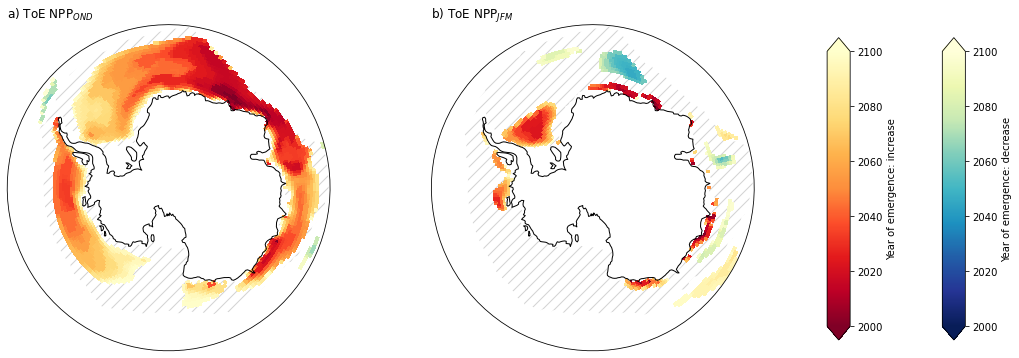

In [38]:
fig = plt.figure(figsize=(16,6))

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE NPP$_{OND}$', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_ond)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_ond)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines('110m',linewidth=1)


######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE NPP$_{JFM}$', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_jfm)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_jfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')

### Make some line plots to go with the maps

In [31]:
ts_SIZ = xr.Dataset()

v='IFRAC_OND'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_OND'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

v='IFRAC_JFM'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_JFM'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

v='IFRAC_AMJ'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_AMJ'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

v='IFRAC_JAS'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_JAS'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

##################################




for v in ['NPP_OND','NPP_JFM','NPP_AMJ','NPP_JAS']:
        
    ######## Whole SIZ
    masked_area = area.where(ds_siz_mask.SIZ==1)
    masked_area['nlat'] = ds_siz_mask.SIZ.nlat
    masked_area['nlon'] = ds_siz_mask.SIZ.nlon
    
    masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
    
    ts_SIZ[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

### SIA

In [41]:
#SIZ
mean = ts_SIZ.SIA_km2_ONDJFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_ONDJFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice = ts_SIZ.SIA_km2_ONDJFM['time'].where(ts_SIZ.SIA_km2_ONDJFM.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val = mean-2*std
print(toe_ice, toe_ice_val)

<xarray.DataArray 'time' ()>
array(1990.) 7021936.908619408


In [32]:
#SIZ
mean = ts_SIZ.SIA_km2_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_OND.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice1 = ts_SIZ.SIA_km2_OND['time'].where(ts_SIZ.SIA_km2_OND.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val1 = mean-2*std
print(toe_ice1, toe_ice_val1)

<xarray.DataArray 'time' ()>
array(1992.) 11295187.02939993


In [33]:
#SIZ
mean = ts_SIZ.SIA_km2_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_JFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice2 = ts_SIZ.SIA_km2_JFM['time'].where(ts_SIZ.SIA_km2_JFM.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val2 = mean-2*std
print(toe_ice2, toe_ice_val2)

<xarray.DataArray 'time' ()>
array(1995.) 2486764.766670249


In [34]:
#SIZ
mean = ts_SIZ.SIA_km2_AMJ.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_AMJ.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice3 = ts_SIZ.SIA_km2_AMJ['time'].where(ts_SIZ.SIA_km2_AMJ.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val3 = mean-2*std
print(toe_ice3, toe_ice_val3)

<xarray.DataArray 'time' ()>
array(1989.) 8457819.298680644


In [35]:
#SIZ
mean = ts_SIZ.SIA_km2_JAS.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_JAS.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice4 = ts_SIZ.SIA_km2_JAS['time'].where(ts_SIZ.SIA_km2_JAS.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val4 = mean-2*std
print(toe_ice4, toe_ice_val4)

<xarray.DataArray 'time' ()>
array(1987.) 13647194.523631714


### NPP

In [37]:
mean = ts_SIZ.NPP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_OND.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp1 = ts_SIZ.NPP_OND['time'].where(ts_SIZ.NPP_OND.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp1_val = mean+2*std
print(toe_npp1,toe_npp1_val)

<xarray.DataArray 'time' ()>
array(1998.) 1461.5418602700784


In [38]:
mean = ts_SIZ.NPP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_JFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp2 = ts_SIZ.NPP_JFM['time'].where(ts_SIZ.NPP_JFM.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp2_val = mean+2*std
print(toe_npp2,toe_npp2_val)

<xarray.DataArray 'time' ()>
array(nan) 2286.057882002542


In [39]:
mean = ts_SIZ.NPP_AMJ.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_AMJ.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp3 = ts_SIZ.NPP_AMJ['time'].where(ts_SIZ.NPP_AMJ.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp3_val = mean+2*std
print(toe_npp3,toe_npp3_val)

<xarray.DataArray 'time' ()>
array(2003.) 84.26950614073013


In [40]:
mean = ts_SIZ.NPP_JAS.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_JAS.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp4 = ts_SIZ.NPP_JAS['time'].where(ts_SIZ.NPP_JAS.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp4_val = mean+2*std
print(toe_npp4,toe_npp4_val)

<xarray.DataArray 'time' ()>
array(1987.) 33.40999467297917


In [41]:
years = np.arange(1920,2100,1)

In [43]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

## Make map for Fig 5 (center): earliest ToE in sea ice

In [44]:
toe_array_ice = xr.concat((ToE_down_ice_ond, ToE_down_ice_jfm),dim='component')
### Take care of nans, by setting them to 10000 so they don't interfere with the min function
toe_array_ice = toe_array_ice.where(toe_array_ice > 1900, other=10000)
earliest_toe_ice = toe_array_ice.min(dim='component')

In [45]:
ones = np.full((55,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

### Antarctic peninsula tip
box1_latmin = -67
box1_latmax = -62
box1_lonmin = -64.
box1_lonmax = -53.

### East Antarctic
box2_latmin = -70
box2_latmax = -65
box2_lonmin = 12.
box2_lonmax = 30.

### Weddell sea 
box3_latmin = -80 #-79
box3_latmax = -72
box3_lonmin = -55 #-50.
box3_lonmax = -32.

### Terre Adelie
box4_latmin = -67
box4_latmax = -65
box4_lonmin = 136.
box4_lonmax = 142.

### Ross Sea
box5_latmin = -78
box5_latmax = -70
box5_lonmin = 165. ## these are in degrees East (crosses dateline)!!...so 170E to 160W
box5_lonmax = 200.

### Amundsen-Bellingshausen
box6_latmin = -75
box6_latmax = -68
box6_lonmin = -120.
box6_lonmax = -80.

### Prydz bay
box7_latmin = -70
box7_latmax = -65
box7_lonmin = 65.
box7_lonmax = 85.

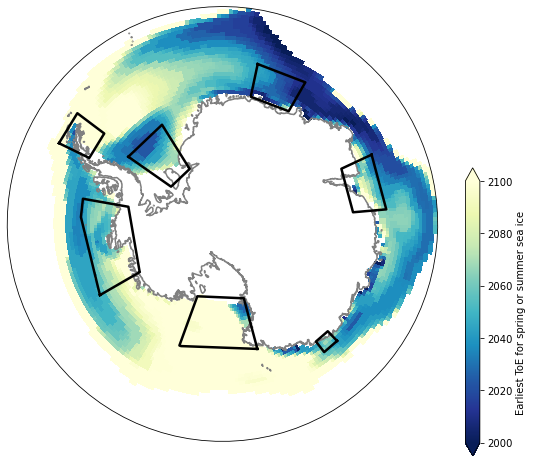

In [46]:
fig = plt.figure(figsize=(10,8))

######## ToE #################################################
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
#ax.set_title('Earliest time of emergence for ice, NPP, and krill growth', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, earliest_toe_ice.where(siz_mask==1))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   #cmap=cmocean.cm.thermal,
                    #cmap='RdYlGn',
                    #cmap='terrain',
                    cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

boxcolor='black'
linethickness = 2.5

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color=boxcolor, linewidth=linethickness,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color=boxcolor, linewidth=linethickness,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color=boxcolor, linewidth=linethickness,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color=boxcolor, linewidth=linethickness,transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color=boxcolor, linewidth=linethickness,transform=ccrs.PlateCarree())

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color=boxcolor, linewidth=linethickness,transform=ccrs.PlateCarree())

lon_pts = [box7_lonmin,box7_lonmax,box7_lonmax,box7_lonmin,box7_lonmin]
lat_pts = [box7_latmax,box7_latmax,box7_latmin,box7_latmin,box7_latmax]
ax.plot(lon_pts, lat_pts, color=boxcolor, linewidth=linethickness,transform=ccrs.PlateCarree())


ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=1.5,color='gray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.80, 0.1, 0.02, 0.5])
cbar1 = fig.colorbar(pc1, cax=cbar_ax, extend='both',label='Earliest ToE for spring or summer sea ice')
fig.savefig(f'{fig_dir}/earliest_toe_ice_regboxes.png', bbox_inches='tight', dpi=300, format='png');

## Figure 1 -revised version

In [47]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', size=13)

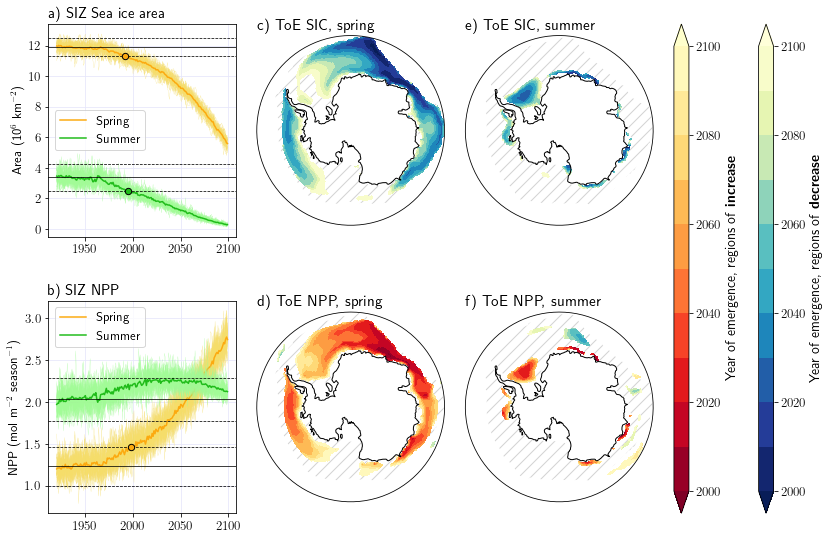

In [48]:
fig = plt.figure(figsize=(13, 9))
gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=(1, 1, 1, 0.08,0.15, 0.08),height_ratios=(1,1))

prj =ccrs.SouthPolarStereo()

ax_sia_line = plt.subplot(gs[0, 0])
ax_npp_line = plt.subplot(gs[1, 0])

ax_sic_map1 = plt.subplot(gs[0, 1], projection=prj)
ax_npp_map1 = plt.subplot(gs[1, 1], projection=prj)

ax_sic_map2 = plt.subplot(gs[0, 2], projection=prj)
ax_npp_map2 = plt.subplot(gs[1, 2], projection=prj)


cb1 = plt.subplot(gs[0:3,3])
cb2 = plt.subplot(gs[0:3,5])

spr_color_ens = (245/255,221/255,106/255)
spr_color_mean = (252/255,170/255,16/255)

sum_color_ens = (162/255,251/255,151/255)
sum_color_mean = (32/255,188/255,26/255)

levels=np.arange(2000,2110,10)

##################################

ax_sia_line.set_title("a) SIZ Sea ice area", loc="left", fontsize=15)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_OND'].isel(member_id=mem)*1e-6, color=spr_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_OND'].mean(dim='member_id')*1e-6,color=spr_color_mean, zorder=2,label='Spring')
mean = ts_SIZ['SIA_km2_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice1,toe_ice_val1*1e-6,s=40,color=spr_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_JFM'].isel(member_id=mem)*1e-6, color=sum_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_JFM'].mean(dim='member_id')*1e-6,color=sum_color_mean, zorder=2,label='Summer')
mean = ts_SIZ['SIA_km2_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice2,toe_ice_val2*1e-6,s=40,color=sum_color_mean,edgecolor='black',zorder=3)
ax_sia_line.legend()
ax_sia_line.xaxis.grid(True, which='major',color='lavender')
ax_sia_line.yaxis.grid(False, which='major',color='lavender');
#ax_sia_line.set_xlabel("Year")
ax_sia_line.set_ylabel("Area (10$^6$ km$^{-2}$)")

#####################

ax_npp_line.set_title("b) SIZ NPP", loc="left", fontsize=15)

for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_OND'].isel(member_id=mem)*0.001, color=spr_color_ens,linewidth=0.2)
    
ax_npp_line.plot(years, ts_SIZ['NPP_OND'].mean(dim='member_id')*0.001,color=spr_color_mean, zorder=2,label='Spring')
mean = ts_SIZ['NPP_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp1,toe_npp1_val*0.001,s=40,color=spr_color_mean,edgecolor='black',zorder=3)
for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_JFM'].isel(member_id=mem)*0.001, color=sum_color_ens,linewidth=0.2)
    
ax_npp_line.plot(years, ts_SIZ['NPP_JFM'].mean(dim='member_id')*0.001,color=sum_color_mean, zorder=2,label='Summer')
mean = ts_SIZ['NPP_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp2,toe_npp2_val*0.001,s=40,color='green',edgecolor='black',zorder=3)
ax_npp_line.legend()
ax_npp_line.xaxis.grid(True, which='major',color='lavender')
ax_npp_line.yaxis.grid(False, which='major',color='lavender');
#ax_npp_line.set_xlabel("Year")
ax_npp_line.set_ylabel("NPP (mol m$^{-2}$ season$^{-1}$)")

##################


############################################################################################## OND ToE maps

################# SIC ToE
ax_sic_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map1.set_title('c) ToE SIC, spring', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_ond)

pc2 = ax_sic_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )


ax_sic_map1.set_boundary(circle, transform=ax_sic_map1.transAxes)
ax_sic_map1.coastlines('110m',linewidth=1)

##########
ax_sic_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map2.set_title('e) ToE SIC, summer', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_jfm)

pc2 = ax_sic_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )

ax_sic_map2.set_boundary(circle, transform=ax_sic_map2.transAxes)
ax_sic_map2.coastlines('110m',linewidth=1)

######################

ax_npp_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map1.set_title('d) ToE NPP, spring', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_ond)

pc1 = ax_npp_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_ond)

pc2 = ax_npp_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )


ax_npp_map1.set_boundary(circle, transform=ax_npp_map1.transAxes)
ax_npp_map1.coastlines('110m',linewidth=1)

###
ax_npp_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map2.set_title('f) ToE NPP, summer', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_jfm)

pc1 = ax_npp_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_jfm)

pc2 = ax_npp_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax_npp_map2.set_boundary(circle, transform=ax_npp_map2.transAxes)
ax_npp_map2.coastlines('110m',linewidth=1)


###########
cbar1 = fig.colorbar(pc1, cax=cb1,extend='both') #,label=r'Year of emergence, regions of \textbf{increase}')
cbar1.set_label(r'Year of emergence, regions of \textbf{increase}', size=14)

cbar2 = fig.colorbar(pc2, cax=cb2,extend='both') #,label=r'Year of emergence, regions of \textbf{decrease}')
cbar2.set_label(r'Year of emergence, regions of \textbf{decrease}', size=14)

fig.subplots_adjust(hspace=0.3)

fig.savefig(f'{fig_dir}/Fig1_ToE_ice_npp_SIZ.png', bbox_inches='tight', dpi=300, format='png');

## Supplementary figures A5 and A6

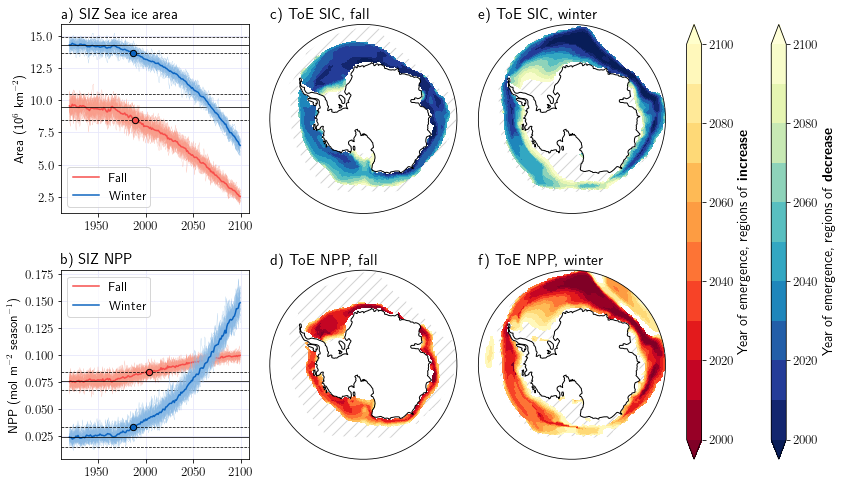

In [49]:
fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=(1, 1, 1, 0.08,0.15, 0.08),height_ratios=(1,1))

prj =ccrs.SouthPolarStereo()

ax_sia_line = plt.subplot(gs[0, 0])
ax_npp_line = plt.subplot(gs[1, 0])

ax_sic_map1 = plt.subplot(gs[0, 1], projection=prj)
ax_npp_map1 = plt.subplot(gs[1, 1], projection=prj)

ax_sic_map2 = plt.subplot(gs[0, 2], projection=prj)
ax_npp_map2 = plt.subplot(gs[1, 2], projection=prj)


cb1 = plt.subplot(gs[0:3,3])
cb2 = plt.subplot(gs[0:3,5])

fall_color_ens = (248/255,157/255,139/255)
fall_color_mean = (247/255,77/255,74/255)

wint_color_ens = (137/255,185/255,228/255)
wint_color_mean = (12/255,100/255,192/255)

##################################

ax_sia_line.set_title("a) SIZ Sea ice area", loc="left", fontsize=15)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_AMJ'].isel(member_id=mem)*1e-6, color=fall_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_AMJ'].mean(dim='member_id')*1e-6,color=fall_color_mean, zorder=2,label='Fall')
mean = ts_SIZ['SIA_km2_AMJ'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_AMJ'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice3,toe_ice_val3*1e-6,s=40,color=fall_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_JAS'].isel(member_id=mem)*1e-6, color=wint_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_JAS'].mean(dim='member_id')*1e-6,color=wint_color_mean, zorder=2,label='Winter')
mean = ts_SIZ['SIA_km2_JAS'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_JAS'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice4,toe_ice_val4*1e-6,s=40,color=wint_color_mean,edgecolor='black',zorder=3)
ax_sia_line.legend()
ax_sia_line.xaxis.grid(True, which='major',color='lavender')
ax_sia_line.yaxis.grid(False, which='major',color='lavender');
#ax_sia_line.set_xlabel("Year")
ax_sia_line.set_ylabel("Area (10$^6$ km$^{-2}$)")

#####################

ax_npp_line.set_title("b) SIZ NPP", loc="left", fontsize=15)

for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_AMJ'].isel(member_id=mem)*0.001, color=fall_color_ens,linewidth=0.2)
    
ax_npp_line.plot(years, ts_SIZ['NPP_AMJ'].mean(dim='member_id')*0.001,color=fall_color_mean, zorder=2,label='Fall')
mean = ts_SIZ['NPP_AMJ'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_AMJ'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp3,toe_npp3_val*0.001,s=40,color=fall_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_JAS'].isel(member_id=mem)*0.001, color=wint_color_ens,linewidth=0.2)
ax_npp_line.plot(years, ts_SIZ['NPP_JAS'].mean(dim='member_id')*0.001,color=wint_color_mean, zorder=2,label='Winter')
mean = ts_SIZ['NPP_JAS'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_JAS'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp4,toe_npp4_val*0.001,s=40,color=wint_color_mean,edgecolor='black',zorder=3)
ax_npp_line.legend()
ax_npp_line.xaxis.grid(True, which='major',color='lavender')
ax_npp_line.yaxis.grid(False, which='major',color='lavender');
#ax_npp_line.set_xlabel("Year")
ax_npp_line.set_ylabel("NPP (mol m$^{-2}$ season$^{-1}$)")


############################################################################################## OND ToE maps

################# SIC ToE
ax_sic_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map1.set_title('c) ToE SIC, fall', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_amj)

pc2 = ax_sic_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )


ax_sic_map1.set_boundary(circle, transform=ax_sic_map1.transAxes)
ax_sic_map1.coastlines('110m',linewidth=1)

##########
ax_sic_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map2.set_title('e) ToE SIC, winter', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_jas)

pc2 = ax_sic_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )

ax_sic_map2.set_boundary(circle, transform=ax_sic_map2.transAxes)
ax_sic_map2.coastlines('110m',linewidth=1)

######################

ax_npp_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map1.set_title('d) ToE NPP, fall', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_amj)

pc1 = ax_npp_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_amj)

pc2 = ax_npp_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax_npp_map1.set_boundary(circle, transform=ax_npp_map1.transAxes)
ax_npp_map1.coastlines('110m',linewidth=1)

###
ax_npp_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map2.set_title('f) ToE NPP, winter', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_jas)

pc1 = ax_npp_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_jas)

pc2 = ax_npp_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )

ax_npp_map2.set_boundary(circle, transform=ax_npp_map2.transAxes)
ax_npp_map2.coastlines('110m',linewidth=1)


###########
cbar1 = fig.colorbar(pc1, cax=cb1,extend='both') #,label=r'Year of emergence, regions of \textbf{increase}')
cbar1.set_label(r'Year of emergence, regions of \textbf{increase}', size=14)

cbar2 = fig.colorbar(pc2, cax=cb2,extend='both') #,label=r'Year of emergence, regions of \textbf{decrease}')
cbar2.set_label(r'Year of emergence, regions of \textbf{decrease}', size=14)
fig.subplots_adjust(hspace=0.3)

fig.savefig(f'{fig_dir}/FigS5_ToE_ice_npp_otherseas.png', bbox_inches='tight', dpi=300, format='png');

### another supplementary figure (SIT ToE)

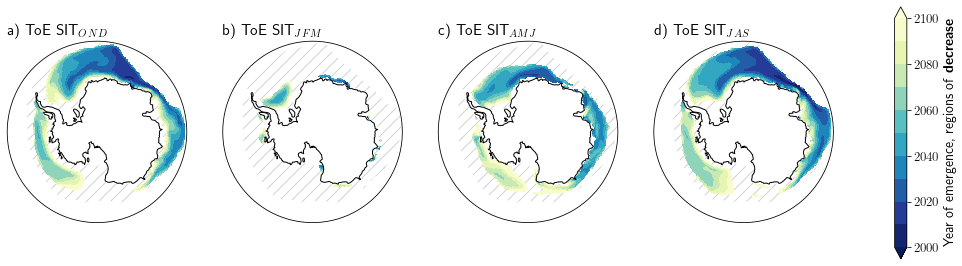

In [50]:
fig = plt.figure(figsize=(17,5))

########################################################
ax = fig.add_subplot(1,4,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE SIT$_{OND}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_ond)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )


ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


#########################################################
ax = fig.add_subplot(1,4,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE SIT$_{JFM}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_jfm)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


#########################################################
ax = fig.add_subplot(1,4,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('c) ToE SIT$_{AMJ}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_amj)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


#########################################################
ax = fig.add_subplot(1,4,4, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('d) ToE SIT$_{JAS}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_jas)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar2 = fig.colorbar(pc2,cax=cbar_ax,extend='both') #,label=r'Year of emergence, regions of \textbf{decrease}')
cbar2.set_label(r'Year of emergence, regions of \textbf{decrease}', size=14)
fig.savefig(f'{fig_dir}/FigS6_ToEmaps_SIT_4seas.png', bbox_inches='tight', dpi=300, format='png');